In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import ase
from ase.io import read,write
from ase.visualize import view
from glob import glob
from copy import copy
from tqdm import tqdm_notebook
import cPickle as pck

In [3]:
import sys,os
sys.path.insert(0,'../')

In [4]:
from ml_tools.descriptors import RawSoapInternal
from ml_tools.models import FullCovarianceTrainer,SoRTrainer
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score,load_pck
from ml_tools.split import KFold,LCSplit,ShuffleSplit
from ml_tools.model_selection import CrossValidationScorer
from ml_tools.model_selection import GridSearch
from ml_tools.compressor import FPSFilter

In [5]:
# filename of the molecular crystal structures
fn = './data/CSD500.xyz'
# atomic type for which to predict chemical shieldings
sp = 1
# atomic types present in the structures
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
# parameters for the soap descriptor
soap_params = dict(rc=4, nmax=8, lmax=6, awidth=0.4,
                   global_species=global_species,
                   nocenters=nocenters,
                   disable_pbar=True)

self_contribution = {1:0., 6:0., 7:0., 8:0.}

## utils

In [6]:
def get_sp_mapping(frames,sp):
    ii = 0
    fid2gids = {it:[] for it in range(len(frames))}
    for iframe,cc in enumerate(frames):
        for ss in cc.get_atomic_numbers():
            if ss == sp:
                fid2gids[iframe].append(ii)
                ii += 1
    return fid2gids

def extract_chemical_shielding(frames,sp):
    prop = []
    for cc in frames:
        numb = cc.get_atomic_numbers()
        prop.extend(cc.get_array('CS')[numb==sp])
    y = np.array(prop)
    return y

# train and predict

In [7]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [8]:
zeta = 2

representation = RawSoapInternal(**soap_params)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)



In [9]:
X_train = representation.transform(frames_train)
trainer.precompute(y_train, X_train)

(650, 650) (650, 7168) (650, 7168)


In [10]:
model = trainer.fit(sigmas=[1e-2])

In [11]:
frames_test = read(fn,index='10:20')
y_test = extract_chemical_shielding(frames_test,sp)

In [12]:
y_pred = model.predict(frames_test)
get_score(y_pred,y_test)

(486, 650) (486, 7168) (650, 7168)


{'CORR': 0.8549624772823136,
 'MAE': 1.335958006886679,
 'R2': 0.7235301553149263,
 'RMSE': 1.9001659625937717,
 'SUP': 8.263027376724523}

# FPS selection of the samples

In [7]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [8]:
zeta = 2
Nselect = 10
representation = RawSoapInternal(**soap_params)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)

kernel = trainer.kernel
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)

In [9]:
rawsoaps = representation.transform(frames_train)

(650, 650) (650, 7168) (650, 7168)


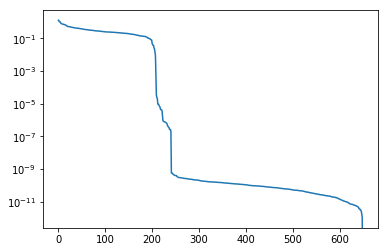

In [10]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [13]:
compressor.Nselect = 250
X = compressor.transform(rawsoaps)

# CV

In [ ]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [ ]:
delta = np.std(y)*0.01
zeta = 2
jitter = 1e-8


kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)


cv = EnvironmentalKFold(n_splits=6,random_state=10,shuffle=True,mapping=mapping)
krr = KRRFastCV(jitter,cv)

In [ ]:
rawsoaps = representation.transform(frames)

In [ ]:
Kmat = kernel.transform(rawsoaps)
krr.fit(Kmat,y)
y_pred = krr.predict()
get_score(y_pred,y)

## test with sparse kernel

### ref

In [ ]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':100')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [ ]:
delta = np.std(y)*0.01
zeta = 2
jitter = 1e-8
Nselect = 10

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kern = KernelPower(zeta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kern,act_on='sample',precompute_kernel=True,disable_pbar=True)
#filt = SymmetryFilter(threshold=1e-4,species=[sp])

cv = EnvironmentalKFold(n_splits=6,random_state=10,shuffle=True,mapping=mapping)
krr = KRR(jitter,delta,trainer)

In [ ]:
rawsoaps = representation.transform(frames)

In [ ]:
#X_filt, y_filt = filt.fit_transform(dict(frames=frames,feature_matrix=rawsoaps),y=y)

In [ ]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [ ]:
X_pseudo = rawsoaps[compressor.selected_ids[:3000]]
kernel = KernelSparseSoR(kern,X_pseudo=X_pseudo,Lambda=0.1)
scores = []
error = []
y_pred = np.ones(y.shape)
for train,test in cv.split(rawsoaps):
    Ktrain,ytrain = kernel.transform(X=rawsoaps[train],y=y[train]) 
    Ktest = kernel.transform(X=rawsoaps[test]) 
    krr.fit(Ktrain,ytrain)
    y_pred[test] = krr.predict(Ktest)
    #error.extend(y_pred-y[test])
    #scores.append(get_score(y_pred,y[test]))
#score = (np.mean(np.abs(error)),np.sqrt(np.mean(np.square(error))))
score = get_score(y_pred,y)
print score

# LC

In [ ]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':20')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [ ]:
delta = np.std(y)
zeta = 2
jitter = 1e-8

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,trainer)


In [ ]:
rawsoaps = representation.transform(frames)
K = kernel.transform(rawsoaps)

In [ ]:
lc = LCSplit(EnvironmentalShuffleSplit, n_repeats=[5,5],train_sizes=[5,10],test_size=10, random_state=10,mapping=mapping)


In [ ]:
score = []
for train,test in tqdm_notebook(lc.split(rawsoaps),total=lc.n_splits):
    k_train = K[np.ix_(train,train)]
    y_train = y[train]
    k_test = K[np.ix_(test,train)]
    krr.fit(k_train,y_train)
    y_pred = krr.predict(k_test)
    score.append(get_score(y_pred,y[test]))

In [ ]:
35000**2*8/1e9

# Procedure of the paper (updated)

## detect outlier in the train set

In [ ]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)


In [ ]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])


In [ ]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [ ]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [ ]:
np.random.seed(10)
seeds = np.random.randint(low=0,high=1000,size=(100,))
preds = []
for seed in tqdm_notebook(seeds):
    cv = EnvironmentalKFold(n_splits=3,random_state=seed,shuffle=True,mapping=mapping)
    krr = KRRFastCV(jitter,cv)
    
    krr.fit(Kmat,y_filt)
    
    yp_filt = krr.predict()
    _,y_pred = filt.inverse_transform(y=yp_filt)
    preds.append(y_pred)
preds = np.array(preds)

In [ ]:
m = np.mean(preds-y_train,axis=0)
s = np.std(preds-y_train,axis=0)

In [ ]:
plt.plot(s,'o',ms=2,)
plt.plot(3*s.mean()*np.ones(len(m)),'-',ms=2,)

In [ ]:
plt.plot(y_train,'o',ms=2)
plt.plot(np.where(s>3*s.mean())[0],y_train[s>3*s.mean()],'ro',ms=2,)

In [ ]:
mapping_sp = get_sp_mapping(frames_train,sp)

iii = np.where(s>3*s.mean())[0]
suspicious_center = iii
sp,name=1,'ccsd'
suspicious_frame = []
for icenter in iii:
    for iframe,centers in mapping_sp.iteritems():
        if icenter in centers:
            suspicious_frame.append(iframe)
            break

#print np.unique(suspicious_frame)
suspicious_frame = np.unique(suspicious_frame)
suspicious_frame

## FPS filtering

In [ ]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [ ]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [ ]:
delta = np.std(y_train)
zeta = 2
Nselect = 6

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
filt = SymmetryFilter(threshold=1e-4,species=[sp])

In [ ]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)


In [ ]:
compressor.fit(X_filt,dry_run=True)
compressor.plot()

## CV score for a model

In [ ]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [ ]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

In [ ]:
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [ ]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8
Nselect = 1000

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)


In [ ]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [ ]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [ ]:
cv = EnvironmentalKFold(n_splits=10,random_state=seed,shuffle=True,mapping=mapping)
krr = KRRFastCV(jitter,delta,cv)

In [ ]:

krr.fit(Kmat,y_filt)

yp_filt = krr.predict()
_,y_pred = filt.inverse_transform(y=yp_filt)

get_score(y_train,y_pred)

In [ ]:
rawsoaps = representation.transform(frames_test)

Ktest = kernel.transform(X_filt,rawsoaps)

In [ ]:
trainer = TrainerCholesky(memory_efficient=True)
krr = KRR(jitter,delta,trainer)
krr.fit(Kmat,y)
y_pred = krr.prediction(Ktest)
